In [1]:
from util import *

import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

#import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
batch_size = 4
file_path = "./CIFAR10"

In [24]:
from torch.optim.optimizer import Optimizer, required
import copy

class AccSGD(Optimizer):

    def __init__(self, params, lr=required, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

Вот здесь большая часть кода, откуда взята реализация (официальный репо pytorch)
https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py

Реализация VGG https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py

## Data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

valid_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
valid_size=0.15
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, 
               batch_size=batch_size, sampler=train_sampler,
               num_workers=2)

validloader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=batch_size, sampler=valid_sampler,
               num_workers=2)

In [6]:
batchs_per_epoch = len(trainloader) / batch_size

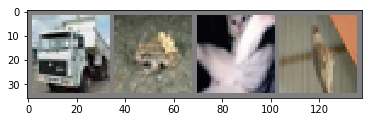

truck	 frog	  cat	 bird


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(validloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Models

### Cifarnet

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### VGG16

In [9]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 
              512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 
              'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


#def test():
#    net = VGG('VGG16')
#    x = torch.randn(2,3,32,32)
#    y = net(x)
#    print(y.size())

## Train

In [10]:
import math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward()
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [11]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, validloader=None, eps=1e-5, print_every=1):
    tr_loss, val_loss, lips, times, grad, acc = ([] for i in range(6))
    start_time = time.time()
    model.to(device=device)
    for ep in range(n_epochs):
        model.train()
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            tr_loss.append(model_step(model, optimizer, criterion, inputs, labels))
            if optimizer.__class__.__name__ == 'SUG':
                lips.append(optimizer.get_lipsitz_const())
                grad.append(optimizer.get_sq_grad)
        times.append(time_since(start_time))
        if ep % print_every == 0:
            print("Epoch {}, training loss {}, time passed {}".format(ep, sum(tr_loss[-i:]) / i, time_since(start_time)))

        if validloader is None:
            continue
        model.zero_grad()
        model.eval()
        j = 0
        for j, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            val_loss.append(model_step(model, optimizer, criterion, inputs, labels))
        if ep % print_every == 0:
            print("Validation loss {}".format(sum(val_loss[-j:]) / j))
        
    return tr_loss, times, val_loss, lips, grad

In [12]:
def concat_states(state1, state2):
    states = {
            'epoch': state1['epoch'] + state2['epoch'],
            'state_dict': state2['state_dict'],
            'optimizer': state2['optimizer'],
            'tr_loss' : state1['tr_loss'] + state2['tr_loss'],
            'val_loss' : state1['val_loss'] + state2['val_loss'],
            'lips' : state1['lips'] + state2['lips'],
            'grad' : state1['grad'] + state2['grad'],
            'times' : state1['times'] + list(map(lambda x: x + state1['times'][-1],state2['times']))
             }
    return states

In [20]:
print_every = 2
n_epochs = 8
tr_loss = {}
tr_loss['accSGD'] = {}
tr_loss['Adam'] = {}
tr_loss['amsgrad'] = {}
tr_loss['sug'] = {}
val_loss = {}
val_loss['accSGD'] = {}
val_loss['Adam'] = {}
val_loss['amsgrad'] = {}
val_loss['sug'] = {}
lrs = [0.001]
criterion = nn.CrossEntropyLoss(reduction="mean")

In [21]:
for lr in lrs:
    model = CNN()
    print("Adam  lr={}:".format(lr))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    tr_loss['Adam'][lr], times, val_loss['Adam'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['Adam'][lr],
            'val_loss' : val_loss['Adam'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/CNN_Adam_' + str(lr))

Adam  lr=0.001:
Epoch 0, training loss 1.5619059246936702, time passed 0m 55s
Validation loss 1.395797265600115
Epoch 2, training loss 1.1838692916088727, time passed 3m 6s
Validation loss 1.2989325432251968
Epoch 4, training loss 1.0678610850366796, time passed 5m 16s
Validation loss 1.2283723291124962
Epoch 6, training loss 0.9927264514771228, time passed 7m 27s
Validation loss 1.1363938888982177


In [22]:
for lr in lrs:
    model = CNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-8, amsgrad=True)
    tr_loss['amsgrad'], times, val_loss['amsgrad'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                                         
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['amsgrad'],
            'val_loss' : val_loss['amsgrad'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './CIFAR10/CNN_amsgrad')

Epoch 0, training loss 1.5522522529031721, time passed 0m 57s
Validation loss 1.3503651137731119
Epoch 2, training loss 1.120953838430704, time passed 3m 9s
Validation loss 1.127311502125118
Epoch 4, training loss 0.9526293033156095, time passed 5m 19s
Validation loss 1.1745965771671294
Epoch 6, training loss 0.8406512876944504, time passed 7m 36s
Validation loss 1.04886676289992


In [25]:
model = CNN()
optimizer = AccSGD(model.parameters(), lr=0.001, kappa = 1000.0, xi = 10.0)
tr_loss['accSGD'], times, val_loss['accSGD'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                          
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['accSGD'],
            'val_loss' : val_loss['accSGD'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './CIFAR10/CNN_accSGD')

Epoch 0, training loss 1.8840586420664767, time passed 0m 46s
Validation loss 1.8811800922629927
Epoch 2, training loss 1.2625865861549075, time passed 2m 33s
Validation loss 1.6384652144372018
Epoch 4, training loss 1.0880282887212753, time passed 4m 1s
Validation loss 1.2731956700568774
Epoch 6, training loss 0.9781017270982715, time passed 5m 28s
Validation loss 1.1477524315184946


In [ ]:
for lr in lrs:
    model = CNN()
    optimizer = SUG(model.parameters(), l_0=lr, momentum=0, nesterov=False)
    tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './CIFAR10/CNN_sug')

In [25]:
l_0 = 2
model = CNN()
#n_epochs = 4
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.)
tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
        }
torch.save(states, './CIFAR10/CNN_sug')

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1435ef630>>
Traceback (most recent call last):
  File "/Users/Pablo/anaconda3/envs/iad/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/Users/Pablo/anaconda3/envs/iad/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/Pablo/anaconda3/envs/iad/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/Users/Pablo/anaconda3/envs/iad/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 167, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/torch/lib/libshm/core.cpp:99


ValueError: mean is not a valid value for reduction

In [26]:
model = CNN()
#n_epochs = 4
optimizer = optim.Adam(model.parameters(), lr=0.005)
tr_loss['adam'], times, val_loss['adam'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['adam'],
            'val_loss' : val_loss['adam'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
        }
torch.save(states, './CIFAR10/CNN_adam')

ValueError: mean is not a valid value for reduction